# Multi-Scenario MORDM Holistic Approach
This Jupyter Notebook uses the model developed by [Ciullo et al. (2019)](https://scholar.google.com/citations?hl=en&user=fDZCVVYAAAAJ&view_op=list_works&sortby=pubdate#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DfDZCVVYAAAAJ%26sortby%3Dpubdate%26citation_for_view%3DfDZCVVYAAAAJ%3AqjMakFHDy7sC%26tzom%3D-120) and the [ema_workbench by Jan Kwakkel](https://github.com/quaquel/EMAworkbench) to evaluate possible strategies for the Gelderland province to increase its resilience to flood risk. It is specifically aimed towards finding optimal strategies from a holistic point of view, namely decreasing damages and casualties all along the Ijssel River. By conducting this analysis, the province of Gelderland, as well as other actors, are provided with optimal policies which serve a common goal. 

## Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px


# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator, Policy)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords, prim


ema_logging.log_to_stderr(ema_logging.INFO)


E:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Logger EMA (DEBUG)>

## General Model Setup
Here, we specify the numbers for the experiment and optimization runs to perform.

In [2]:
# Number of nfes for the Model
n_nfe = 20000

#Number of scenarios for the deep uncertainty evaluation of promising scenarios
n_scenarios = 1000

#Path to the reference scenarios to use for MORDM
path_noaction = "../results/10000Scenarios_NoAction_PF1.tar.gz"

## Model Specification

In [3]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(2)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [4]:
experiments, outcomes = load_results(path_noaction)

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\10000Scenarios_NoAction_PF1.tar.gz


In [5]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=n_nfe, epsilons=[0.1,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 5: 497/20000 nfe
[MainProcess/INFO] generation 10: 993/20000 nfe
[MainProcess/INFO] generation 15: 1491/20000 nfe
[MainProcess/INFO] generation 20: 1990/20000 nfe
[MainProcess/INFO] generation 25: 2490/20000 nfe
[MainProcess/INFO] generation 30: 2989/20000 nfe
[MainProcess/INFO] generation 35: 3484/20000 nfe
[MainProcess/INFO] generation 40: 3982/20000 nfe
[MainProcess/INFO] generation 45: 4480/20000 nfe
[MainProcess/INFO] generation 50: 4980/20000 nfe
[MainProcess/INFO] generation 55: 5479/20000 nfe
[MainProcess/INFO] generation 60: 5978/20000 nfe
[MainProcess/INFO] generation 65: 6478/20000 nfe
[MainProcess/INFO] generation 70: 6975/20000 nfe
[MainProcess/INFO] generation 75: 7473/20000 nfe
[MainProcess/INFO] generation 80: 7971/20000 nfe
[MainProcess/INFO] generation 85: 8467/20000 nfe
[MainProcess/INFO] generation 90: 8964/20000 nfe
[MainProcess/INFO] generation 95: 9461/20000

In [7]:
results, convergence = results_epsilon_0_1

In [8]:
# Save Results
save_results(results_epsilon_0_1, "../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Holistic.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\20000nfe_BaseCaseMORDM_Holistic.tar.gz


In [6]:
# Load Results
results_epsilon_0_1 = load_results("../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Holistic.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/5000nfe_BaseCaseMORDM.tar.gz


In [33]:
# Load Results
results_epsilon_0_1 = load_results("../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Holistic.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\20000nfe_BaseCaseMORDM_Holistic.tar.gz


In [38]:
results_epsilon_0_1[0].iloc[:,31::]

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,3.241714e+05,5.960381e+08,146000000.0,0.000000,0.000194
1,0.000000e+00,4.921108e+08,176700000.0,0.000000,0.000000
2,4.440652e+06,6.128632e+08,0.0,192.935824,0.000936
3,2.082337e+06,3.774044e+08,297900000.0,55.507126,0.000900
4,8.890527e+06,3.465869e+08,213300000.0,0.000000,0.006615
...,...,...,...,...,...
596,4.882412e+07,2.522258e+08,146000000.0,2638.856632,0.007059
597,1.047279e+09,1.477884e+08,84600000.0,28791.432094,0.332219
598,9.439675e+08,9.096742e+07,230600000.0,0.000000,0.853233
599,1.903722e+08,1.479054e+08,333100000.0,0.000000,0.214746


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

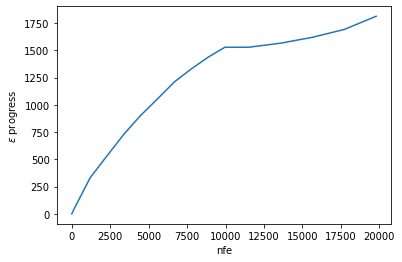

In [9]:
results, convergence = results_epsilon_0_1
convergence = pd.DataFrame(convergence)
plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$ progress')
plt.xlabel('nfe')
plt.show()

## Show tradeoffs in the resulting optimal policies
The algorithm found 440 solutions. 

In [40]:
fig = px.parallel_coordinates(results_epsilon_0_1[0].iloc[:, 31::], color=results_epsilon_0_1[0].index)
fig.update_layout(showlegend=False)
fig.show()

## Re-Evaluate under deep uncertainty
For evaluating the promising policies under deep uncertainty, we set a hard limit on one expected casualties below 0.001 and expected damages below €100.000. 

In [11]:
results_subset = results[
    (results["Expected Number of Deaths"] < 0.001) &
    (results["Expected Annual Damage"] < 100000) ]

We further use the remaining policies to test them under deep uncertainty by running the policies for 1000 scenarios each. 

In [12]:
policies = results_subset.iloc[:,0:31]
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [13]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 7 policies * 1 model(s) = 7000 experiments
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 4900 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 6300 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [14]:
#Save results
save_results(results, "../results/DeepUncertaintyPolicies_Holistic_10000scenarios.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\DeepUncertaintyPolicies_Holistic_10000scenarios.tar.gz


### Signal-to-noise Ratio
To find the most robust policy, we rate the different policies by calculating the signal-to-noise ratio. 

In [15]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [16]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
1,2.265990e+15,58.664174,0.0,6.454714e+05,0.000014
208,1.135511e+15,14.832822,0.0,2.387721e+05,0.000011
285,2.527610e+16,0.000000,0.0,3.499639e+06,0.000146
382,2.618146e+16,0.000000,0.0,1.012667e+06,0.001395
41,2.554325e+16,18.970512,0.0,2.422971e+06,0.000232
477,8.058506e+13,51.781184,0.0,1.362841e+05,0.000001
73,4.152542e+15,25.761610,0.0,4.484635e+05,0.000038


In [32]:
fig = px.parallel_coordinates(scores, labels= {"Annual Damage": 'Expected Annual Damage', "D Investment Costs": 'Dike Investment Costs', "R Investment Costs": 'RfR Investment Costs', "Evac Costs": 'Evacuation Costs', "Expected Deaths": 'Expected Number of Deaths'})
fig.show()

### Maximum Regret
Another robustness criterion is the maximum regret measure. We again calculate this measure for every policy selected

In [18]:
def calculate_regret(data, best):
    return np.abs(best-data)


overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data.pivot(index='scenario', columns='policy')
    
    data.columns = data.columns.get_level_values(1)
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

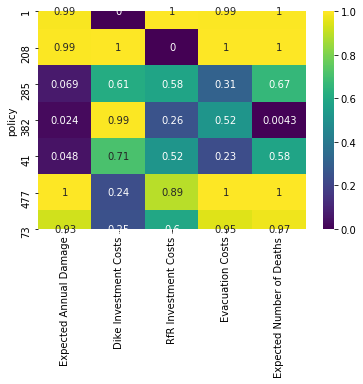

In [19]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [30]:
fig = px.parallel_coordinates(max_regret, labels = {"Annual Damage": 'Expected Annual Damage', "D Investment Costs": 'Dike Investment Costs', "R Investment Costs": 'RfR Investment Costs', "Evac Costs": 'Evacuation Costs', "Expected Deaths": 'Expected Number of Deaths'})
fig.show()

In [31]:
max_regret

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
1,3.003810e+09,0.000000e+00,508200000.0,26072.711992,0.521050
208,3.019276e+09,2.432573e+08,0.0,26190.426949,0.522574
285,2.094152e+08,1.495875e+08,296500000.0,8195.015247,0.348759
382,7.148955e+07,2.415169e+08,130900000.0,13638.955029,0.002224
41,1.448563e+08,1.738384e+08,265800000.0,6063.064992,0.305396
477,3.035094e+09,5.773870e+07,454300000.0,26241.469483,0.523133
73,2.812169e+09,5.990267e+07,302400000.0,24966.651287,0.509966


In [27]:
outcomes.keys()

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths', 'selection'])

## Scenario Discovery
We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. We focus on such scenarios where death and damages occur.

In [23]:
x = experiments.iloc[:,0:19]

outcomes["selection"] = outcomes["Expected Annual Damage"] + outcomes["Expected Number of Deaths"]

y =  outcomes["selection"] > 0 
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 7000 points remaining, containing 1910 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.057, coverage: 0.2089005235602094, density: 1.0 restricted_dimensions: 5


In [24]:
box.inspect_tradeoff()


alt.VConcatChart(...)

We select box 29, as it shows a good mixture between coverage and density

In [25]:
box.inspect(52)


coverage    0.218848
density     0.995238
id                52
mass            0.06
mean        0.995238
res_dim            5
Name: 52, dtype: object

              box 52                                            
                 min         max                       qp values
A.4_pfail   0.000075    0.077152  [-1.0, 9.031378697557045e-263]
A.5_pfail   0.000367    0.949760      [-1.0, 0.7183244793043442]
A.4_Bmax   73.010641  349.697001     [0.09509423472877235, -1.0]
A.1_pfail   0.096768    0.999993      [0.1520382868082641, -1.0]
A.2_Bmax   46.243793  349.793825        [0.67667693010055, -1.0]



In [26]:
box.select(52)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}
#Save results
save_results((scens_in_box, outcomes_in_box), '../results/mordm_holistic_52.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\model-based-decision-making\results\mordm_holistic_52.tar.gz


# Multi-Scenario MORDM
Based on the results of scenario discovery, we now continue to select three of such scenarios based on the worst outcomes in terms of casualties, damages and total costs. We will take each of these scenarios as a reference scenario to run an optimization algorithm for the levers to choose. 